In [0]:
%run ./00_helpers

Python interpreter will be restarted.
Processing /dbfs/FileStore/jars/82a8f80e_8266_43fb_be3c_12ac7a64dc2d/maas_utils-0.2.0-py3-none-any.whl
Installing collected packages: maas-utils
Successfully installed maas-utils-0.2.0
Python interpreter will be restarted.
Python interpreter will be restarted.
Collecting mlflow==1.18.0
 Using cached mlflow-1.18.0-py3-none-any.whl (14.2 MB)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (2020.5)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (1.1.2)
Collecting sqlalchemy
 Using cached SQLAlchemy-1.4.37-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (1.2.4)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (0.4.1)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (3.1.12)
Collecting alembic<=1.4.1
 Using cached alembic-1.4.1-py2.py3-none-any.whl
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (1.20.1)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (0.16.3)
Requirement already satisfied: protobuf>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (3.17.2)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (2.25.1)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (1.6.0)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (7.1.2)
Requirement already satisfied: gunicorn in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (20.0.4)
Collecting docker>=4.0.0
 Using cached docker-5.0.3-py2.py3-none-any.whl (146 kB)
Collecting querystring-parser
 Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
Requirement already satisfied: pyyaml>=5.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (5.4.1)
Requirement already satisfied: packaging in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (21.3)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow==1.18.0) (0.3)
Collecting prometheus-flask-exporter
 Using cached prometheus_flask_exporter-0.20.1-py3-none-any.whl (18 kB)
Requirement already satisfied: python-dateutil in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow==1.18.0) (2.8.1)
Requirement already satisfied: python-editor>=0.3 in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow==1.18.0) (1.0.4)
Requirement already satisfied: Mako in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow==1.18.0) (1.1.3)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow==1.18.0) (1.15.0)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow==1.18.0) (0.8.7)
Requirement already satisfied: websocket-client>=0.32.0 in /databricks/python3/lib/python3.8/site-packages (from docker>=4.0.0->mlflow==1.18.0) (0.57.0)
Requirement already satisfied: gitdb<5,>=4.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitpython>=2.1.0->mlflow==1.18.0) (4.0.7)
Requirement already satisfied: smmap<5,>=3.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitdb<5,>=4.0.1->gitpython>=2.1.0->mlflow==1.18.0) (3.0.5)
Requirement already satisfied: certifi>=2017.4.17

In [0]:
import mlflow
from hyperopt import tpe, hp, fmin
import pyspark.sql.functions as F
import uuid
import json

In [0]:
dbutils.widgets.removeAll()

In [0]:
# Params from pre-procesesing notebook 
dbutils.widgets.text(name="train_df_path", defaultValue="dbfs:/tmp/next_product_recommender_train_df", label="Training DF Path")
dbutils.widgets.text(name="train_df_version", defaultValue="5", label="Training DF Version")

# Params needed for this noteoobk 
dbutils.widgets.text(name="experiment_path", defaultValue="/MDA/MODELING_DEV/product_recommender/exploratory_modeling/als/als-models", label="Experiment_name")
dbutils.widgets.dropdown(name="hyperopt_flag", defaultValue="False", choices=["False", "True"])
dbutils.widgets.text(name="model_path", defaultValue="dbfs:/tmp/next_product_recommender/models", label="Model Path")
dbutils.widgets.text(name="implicit_rating_field", defaultValue="implicit_rating_field", label="Implicit Rating Field")

#params for tuning values 
dbutils.widgets.text("alpha", "1", "Alpha Value")
dbutils.widgets.text("beta", "1", "Beta Value")
dbutils.widgets.text("gamma", "1", "Gamma Value")
dbutils.widgets.text("delta", "1", "Delta Value")

In [0]:
train_df_path = dbutils.widgets.getArgument("train_df_path")
train_df_version = dbutils.widgets.getArgument("train_df_version")
experiment_path = dbutils.widgets.getArgument("experiment_path")
hyperopt_flag = dbutils.widgets.getArgument("hyperopt_flag")
model_path = dbutils.widgets.getArgument("model_path")
implicit_rating_field = dbutils.widgets.getArgument("implicit_rating_field")
## get the values from the widgets
alpha = float(dbutils.widgets.getArgument("alpha"))
beta =  float(dbutils.widgets.getArgument("beta"))
gamma = float(dbutils.widgets.getArgument("gamma"))
delta =  float(dbutils.widgets.getArgument("delta"))



In [0]:
# Read in training data 
train_df = (spark
            .read
            .format("delta")
            .option("versionAsOf", train_df_version)
            .load(train_df_path)
           )

display(train_df.agg(F.count("*").alias("total"), F.countDistinct("account_id").alias("total_id")))

total,total_id
64383,2327


In [0]:
# QA - Checking for Nulls once data types are converted 
nulls_df = (train_df
            .select(
              [F.count(F.when(F.isnull(c), c))
               .alias(c) for c in train_df.columns]
            )
           )
display(nulls_df)

product_group_line_type_subtype_platform,account_id,product_group_line_type,product_group_line,num_purchases,total_baskets,total_purchases,pct_purchases,log_num_purchases,num_recent_purchases,total_recent_purchases,pct_recent_purchases,account_name,mintigo_acct_product_score,mintigo_acct_product_score_scaled,implicit_rating,account_cat_id,product_cat_id,product_group_line_type_subtype,intricately_acct_product_score,intricately_acct_product_score_scaled
0,0,64383,35629,0,0,0,0,0,0,0,0,64383,0,0,0,0,0,0,0,0


In [0]:
def tune_with_hyperopt(params):
  """
  Train and return metric to be minimized by hyperopt
  """
  
  rank = int(params['rank'])
  maxIter = int(params['maxIter'])
  regParam = params['regParam']
  alpha = int(params['alpha'])
  
  model, metric, run_id = train_als(train_df=train_df,
                                    rank=rank, 
                                    maxIter=maxIter, 
                                    regParam=regParam, 
                                    alpha=alpha, k=30
                                   )
  
  # hyperopt will minimize
  return -metric

In [0]:
try:
  import mlflow.pyspark.ml
  mlflow.pyspark.ml.autolog()
except:
  print(f"Your version of MLflow ({mlflow.__version__}) does not support pyspark.ml for autologging. To use autologging, upgrade your MLflow client version or use Databricks Runtime for ML 8.3 or above.")

2022/06/02 18:15:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pyspark.ml. If you encounter errors during autologging, try upgrading / downgrading pyspark.ml to a supported version, or try upgrading MLflow.

In [0]:
print(hyperopt_flag)

False

In [0]:
if hyperopt_flag == "True":
  algo = tpe.suggest
  print(algo)
  search_space = {
    'rank': hp.quniform('rank', 5, 40,q=1), 
    'maxIter': hp.quniform('maxIter', 30, 50,q=1),
    'regParam': hp.loguniform('regParam', 0.5, 1), 
    'alpha': hp.quniform('alpha', 10, 30,q=1)
  }

  mlflow.set_experiment(experiment_path)
  with mlflow.start_run(run_name="PARENT_RUN") as parent_run:
    best_params = fmin(fn=tune_with_hyperopt,
                       space=search_space,
                       max_evals=30
                      )
    best_params['rank'] = int(best_params['rank'])
    best_params['maxIter'] = int(best_params['maxIter'])
    best_params['alpha'] = int(best_params['alpha'])

    mlflow.log_params(best_params)
else:
  # TODO: Go to model registry, grab model that's tagged as prod, select that model's hypers and use them as best_params
  # Hard code best params for testing 
  best_params = {"alpha": 30, 
                 "maxIter": 43, 
                 "rank": 37, 
                 "regParam": 1.6499015944515676
                }
  
  


In [0]:
# Print out best params 
best_params

Out[17]: {'alpha': 30, 'maxIter': 43, 'rank': 37, 'regParam': 1.6499015944515676}

In [0]:
# Generate a unique model ID to make is easier to track different versions of models 
model_id = uuid.uuid4().hex[0:4]

2022/06/02 18:15:40 WARNING mlflow.pyspark.ml: Model PipelineModel_37dbedc31dfd will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).
/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

account_cat_id,actuals,predictions
1,"List(21.0, 554.0, 28.0, 606.0, 919.0, 1441.0, 35.0, 577.0, 41.0, 596.0, 585.0, 566.0, 7.0, 568.0, 2.0, 617.0, 24.0, 597.0, 29.0, 16.0, 546.0, 5.0, 8.0, 1.0, 599.0, 46.0, 565.0, 616.0, 581.0)","List(2.0, 21.0, 554.0, 585.0, 596.0, 566.0, 35.0, 571.0, 577.0, 606.0, 28.0, 41.0, 603.0, 36.0, 639.0, 7.0, 568.0, 660.0, 24.0, 23.0, 611.0, 62.0, 578.0, 80.0, 5.0, 617.0, 58.0, 8.0, 616.0, 1.0)"
2,"List(553.0, 113.0, 186.0, 838.0, 93.0, 761.0, 965.0, 672.0, 20.0, 907.0, 960.0, 83.0, 80.0, 188.0, 54.0, 781.0, 576.0, 951.0, 125.0, 716.0, 120.0, 677.0, 608.0, 755.0, 748.0, 903.0, 1029.0, 169.0, 2.0, 601.0, 952.0, 65.0, 889.0, 568.0, 720.0, 578.0, 616.0, 585.0, 639.0, 606.0, 1253.0, 1165.0, 66.0)","List(80.0, 65.0, 601.0, 951.0, 83.0, 608.0, 672.0, 755.0, 716.0, 761.0, 113.0, 553.0, 838.0, 93.0, 965.0, 186.0, 20.0, 169.0, 1029.0, 907.0, 960.0, 188.0, 120.0, 54.0, 781.0, 125.0, 925.0, 576.0, 677.0, 748.0)"
3,"List(35.0, 577.0, 689.0, 851.0, 656.0, 36.0, 1277.0, 639.0, 603.0, 686.0, 244.0, 62.0, 121.0, 606.0, 557.0, 575.0, 31.0, 754.0, 58.0, 82.0, 850.0, 714.0, 736.0, 566.0, 2.0, 41.0, 596.0, 585.0, 568.0, 21.0, 7.0, 599.0, 5.0, 8.0, 1.0, 617.0, 16.0, 29.0, 546.0, 616.0, 565.0, 46.0, 597.0, 24.0, 581.0)","List(2.0, 606.0, 603.0, 21.0, 571.0, 554.0, 585.0, 36.0, 596.0, 566.0, 35.0, 577.0, 28.0, 23.0, 41.0, 58.0, 639.0, 62.0, 568.0, 7.0, 24.0, 557.0, 609.0, 5.0, 617.0, 8.0, 660.0, 616.0, 45.0, 561.0)"
4,"List(937.0, 585.0, 21.0, 917.0, 28.0, 338.0, 180.0, 1414.0, 1132.0, 1380.0, 264.0, 545.0, 1376.0, 606.0, 721.0, 566.0, 568.0, 1012.0, 58.0, 45.0, 1251.0, 301.0, 25.0, 62.0, 729.0, 639.0, 764.0, 596.0, 577.0, 24.0, 35.0, 8.0, 5.0, 7.0, 16.0, 597.0, 41.0, 617.0, 616.0, 2.0, 581.0)","List(2.0, 21.0, 571.0, 554.0, 606.0, 585.0, 596.0, 566.0, 35.0, 28.0, 577.0, 937.0, 36.0, 603.0, 41.0, 639.0, 23.0, 7.0, 568.0, 24.0, 62.0, 58.0, 660.0, 45.0, 5.0, 617.0, 8.0, 80.0, 25.0, 616.0)"
5,"List(2.0, 35.0, 577.0, 585.0, 41.0, 568.0, 566.0, 21.0, 596.0, 7.0, 8.0, 5.0, 24.0, 1.0, 16.0, 617.0, 616.0, 29.0, 597.0, 581.0)","List(2.0, 21.0, 596.0, 585.0, 554.0, 35.0, 566.0, 577.0, 571.0, 41.0, 28.0, 606.0, 603.0, 639.0, 36.0, 611.0, 7.0, 660.0, 568.0, 24.0, 578.0, 23.0, 80.0, 5.0, 62.0, 617.0, 8.0, 616.0, 1.0, 599.0)"
6,"List(21.0, 32.0, 639.0, 41.0, 734.0, 549.0, 803.0, 596.0, 566.0, 35.0, 577.0, 585.0, 24.0, 28.0, 202.0, 563.0, 659.0, 47.0, 749.0, 1217.0, 989.0, 1200.0, 1114.0, 1338.0, 656.0, 568.0, 2.0, 7.0, 617.0, 8.0, 5.0, 869.0, 29.0, 1.0, 616.0, 581.0, 16.0, 597.0, 546.0, 599.0, 565.0, 46.0)","List(2.0, 28.0, 21.0, 596.0, 585.0, 554.0, 35.0, 566.0, 577.0, 639.0, 571.0, 41.0, 32.0, 606.0, 611.0, 659.0, 803.0, 603.0, 7.0, 568.0, 36.0, 578.0, 24.0, 724.0, 9.0, 80.0, 5.0, 23.0, 563.0, 617.0)"
7,"List(667.0, 611.0, 395.0, 584.0, 1236.0, 89.0, 603.0, 606.0, 557.0, 568.0, 585.0, 8.0, 5.0, 24.0, 16.0, 581.0)","List(606.0, 603.0, 2.0, 557.0, 760.0, 21.0, 554.0, 36.0, 585.0, 571.0, 596.0, 566.0, 35.0, 577.0, 28.0, 23.0, 41.0, 247.0, 611.0, 58.0, 584.0, 568.0, 639.0, 1335.0, 7.0, 24.0, 135.0, 62.0, 201.0, 609.0)"
8,"List(601.0, 755.0, 80.0, 608.0, 65.0, 585.0, 83.0, 169.0, 20.0, 960.0, 120.0, 1029.0, 186.0, 965.0, 93.0, 781.0, 716.0, 188.0, 838.0, 113.0, 553.0, 672.0, 761.0, 54.0, 951.0, 907.0, 566.0, 596.0, 2.0, 577.0, 35.0, 568.0, 41.0, 616.0, 581.0)","List(80.0, 65.0, 601.0, 608.0, 951.0, 83.0, 755.0, 672.0, 716.0, 761.0, 113.0, 553.0, 838.0, 93.0, 169.0, 965.0, 186.0, 20.0, 1029.0, 907.0, 960.0, 188.0, 120.0, 54.0, 781.0, 925.0, 125.0, 576.0, 677.0, 748.0)"
9,"List(1389.0, 571.0, 131.0, 193.0, 585.0)","List(193.0, 139.0, 571.0, 1389.0, 1143.0, 855.0, 1285.0, 102.0, 130.0, 834.0, 85.0, 603.0, 561.0, 703.0, 582.0, 2.0, 1121.0, 1051.0, 930.0, 415.0, 21.0, 585.0, 596.0, 884.0, 1293.0, 566.0, 23.0, 35.0, 97.0, 577.0)"
10,"List(578.0, 611.0, 2.0, 585.0, 35.0, 577.0, 566.0, 41.0, 596.0, 599.0, 616.0, 568.0, 565.0, 546.0)","List(2.0, 611.0, 21.0, 596.0, 585.0, 578.0, 35.0, 566.0, 577.0, 554.0, 41.0, 28.0, 571.0, 639.0, 32.0, 7.0, 606.0

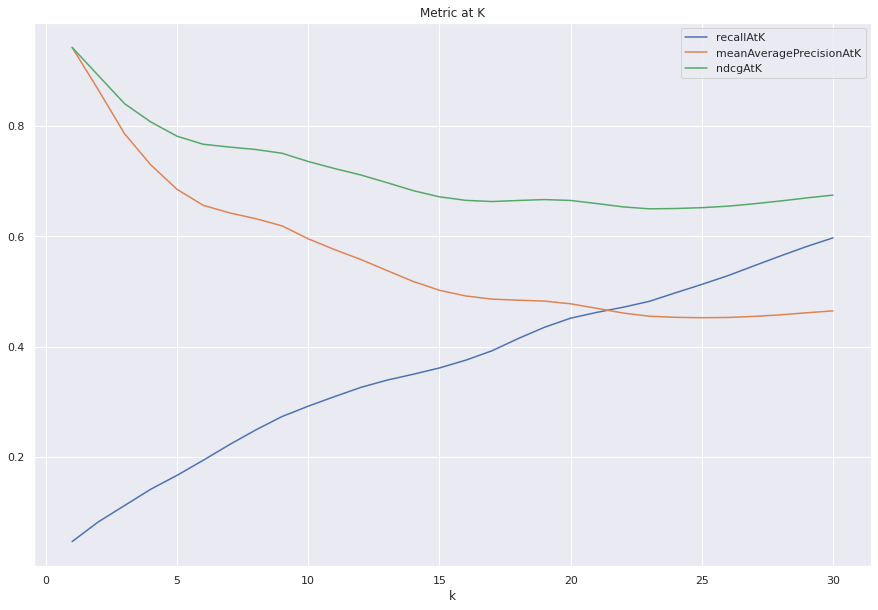

In [0]:
# Train model and get recommendations

mlflow.set_experiment(experiment_path)
model_id = uuid.uuid4().hex[0:4]

#Add model registry here to track best params 
with mlflow.start_run(run_name=f"best_run_{uuid}") as run:
  ALSImplicit = ALS(implicitPrefs=True,
                    userCol="account_cat_id",
                    itemCol="product_cat_id",
                    ratingCol=implicit_rating_field,
                    coldStartStrategy="drop",
                    rank=best_params["rank"],
                    maxIter=best_params["maxIter"], 
                    regParam=best_params["regParam"],
                    alpha=best_params["alpha"]
                   )
  stages = [ALSImplicit]
  pipeline = Pipeline(stages=stages)
  model = pipeline.fit(train_df)
  
  # Setting tags with the training data and version
  run_id = run.info.run_id
  tags = {"training_df_path": train_df_path, 
          "training_df_version": train_df_version,
          "run_id":run_id
         }
  mlflow.set_tags(tags)
  mlflow.log_params(best_params)
  mlflow.log_param("alpha_m", alpha)
  mlflow.log_param("beta", beta)
  mlflow.log_param("gamma", gamma)
  mlflow.log_param("delta", delta)
  
  # generate predictions using fitted model
  preds = predict(model,
                 "account_cat_id",
                 "product_cat_id",
                 k=30
                 )
  
  # Preprocess actuals and preds array of products for evaluation 
  eval_df = evaluation_pre_proccessing(actual_df=train_df,
                                       pred_df=preds,
                                       rating_col=implicit_rating_field,
                                       user_col="account_cat_id",
                                       item_col="product_cat_id"
                                      )

  # evaluate / metrics
  metrics_plot_file = "/dbfs/FileStore/als_metric_at_k_plot.png"
  metrics_at_k = generate_evaluation_metrics(evaluation_df=eval_df,
                                             max_k=30+1,
                                             path=metrics_plot_file
                                            )

  ### Save features list to txt
  metrics_at_k_json = '/dbfs/FileStore/als_metrics_at_k.json'
  with open(metrics_at_k_json, 'w') as outfile: 
    json.dump(metrics_at_k, outfile)
 
  mlflow.log_artifact(metrics_at_k_json)  

  plt.savefig(metrics_plot_file)
  mlflow.log_artifact(metrics_plot_file)

  ### Log metrics as k as json
  metrics_at_k_json = '/dbfs/FileStore/als_metrics_at_k.json'
  with open(metrics_at_k_json, 'w') as outfile: 
    json.dump(metrics_at_k, outfile)

  mlflow.log_artifact(metrics_at_k_json)


  # flatter metrics at k dictionary for metric logging
  metrics_at_k_flat = {outer_k: {str(inner_k): inner_v for inner_k, inner_v in outer_v.items()} for outer_k, outer_v in metrics_at_k.items()}
  mlflow.log_metrics(dict(flatdict.FlatDict(metrics_at_k_flat,delimiter='_')))
  
  # Write the model out to a location to use for inference 
  model_path = f"{model_path}_{run_id}"
  
    # HACK  due to engineering bug with ALS that writes intermediate objects in delta but the pipeline reader checks for it in parquet - should be changed in an updated runtime
  spark.conf.set("spark.databricks.delta.formatCheck.enabled", "false")
  
  # Write out the model 
  model.write().overwrite().save(model_path)
  
  tags = {"model_path": model_path
         }
  mlflow.set_tags(tags)

  display(eval_df)



In [0]:
model_path

Out[20]: 'dbfs:/tmp/next_product_recommender/models'

In [0]:
return_dict = {
  "experiment_path": experiment_path, 
  "model_path": model_path,
  "mlflow_run_id": run_id
}

In [0]:
dbutils.notebook.exit(json.dumps(return_dict))

{"experiment_path": "/MDA/MODELING_DEV/product_recommender/exploratory_modeling/als_models", "model_path": "dbfs:/tmp/next_product_recommender/models_73d451d68d1848c597b630f477838b18", "mlflow_run_id": "73d451d68d1848c597b630f477838b18"}